<a href="https://colab.research.google.com/github/H3IN-THANT/FirstTest/blob/master/ImageTagging_Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

In [24]:

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10


In [19]:
def loadAndPreData(x_train, y_train, x_test0, y_test0):

  VALIDATION_SPLIT = 0.15
  test_imgs = x_test0.shape[0]
  num_val_samples = int(VALIDATION_SPLIT * test_imgs)

  x_val, x_test = x_test0[:num_val_samples], x_test0[num_val_samples:]
  y_val, y_test = y_test0[:num_val_samples], y_test0[num_val_samples:]

  def make_ds(x, y):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [IMG_HEIGHT, IMG_WIDTH])/255.0, y))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

  x_train = x_train.astype('float32') / 255.0
  x_test = x_test.astype('float32') / 255.0
  x_val = x_val.astype('float32') / 255.0

  y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
  y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
  y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

  train_ds = make_ds(x_train, y_train)
  val_ds = make_ds(x_val, y_val)
  test_ds = make_ds(x_test, y_test)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_ds, val_ds, test_ds

In [4]:
def show_shuffled_img(x_test, y_test):

  indices = np.arange(len(x_test))
  np.random.shuffle(indices)
  indices = indices[:10]

  x_test_shuffled = x_test[indices]
  y_test_shuffled = y_test[indices]

  plt.figure(figsize=(15, 4))
  for i in range(10):
    img = x_test_shuffled[i]
    label_idx = np.argmax(y_test_shuffled[i])
    label_name = class_names[label_idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label_name)
  plt.tight_layout()
  plt.show()

In [ ]:
# def build_CNN():
#     model = models.Sequential([
#         layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

#         layers.Conv2D(32, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.Conv2D(32, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),

#         layers.Conv2D(64, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),

#         layers.Conv2D(128, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),

#         layers.Conv2D(256, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),

#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(NUM_CLASSES, activation='softmax')
#     ])
#     return model

In [5]:
def build_CNN():
    model = models.Sequential([
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(NUM_CLASSES, activation='sigmoid')
    ])
    return model

In [6]:
def create_dataGen():
  datagen = ImageDataGenerator(
      rotation_range = 30,
      width_shift_range = 0.15,
      height_shift_range = 0.15,
      shear_range = 0.15,
      zoom_range = 0.15,
      horizontal_flip = True,
      fill_mode = 'nearest'
  )

  return datagen

In [7]:
def get_optimizer(learning_rate= 0.001):
  return tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [8]:
def eval_model(model, test_ds):
  test_loss, test_acc = model.evaluate(test_ds, verbose = 2)
  print('\nTest Accuracy: {:.2f}%'.format(test_acc*100))

  print("Generating classification report...")
  y_pred_probs = model.predict(test_ds)
  y_pred = np.argmax(y_pred_probs, axis = 1)

  y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

  report = classification_report(y_true, y_pred)
  print(report)

  print("Confusion matrix...")
  cm = confusion_matrix(y_true, y_pred)
  print(cm)

In [21]:
def main():
    print("Loading and preprocessing data...")

    (x_train, y_train), (x_test0, y_test0) = tf.keras.datasets.cifar10.load_data()

    (x_train, y_train), (x_val, y_val), (x_test, y_test), train_ds, val_ds, test_ds = loadAndPreData(
        x_train, y_train, x_test0, y_test0
    )

    print("Creating data generator with augmentation...")
    datagen = create_dataGen()

    print("Showing shuffled 10 images...")
    show_shuffled_img(x_test, y_test)

    print("Building CNN model...")
    model = build_CNN()
    model.summary()
    print("Model input shape:", model.input_shape)
    print("Model output shape:", model.output_shape)

    optimizer = get_optimizer(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print("Training model with augmented data...")
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)

    print("Evaluating model on test data...")
    eval_model(model, test_ds)

    save_path = "image_tagging_model.h5"
    model.save(save_path)
    print(f"Model saved to {save_path}")

    print("Loading saved model for test prediction...")
    loaded_model = tf.keras.models.load_model(save_path)

    sample_img = x_test0[0:1]
    resized_img = tf.image.resize(sample_img, [IMG_HEIGHT, IMG_WIDTH])
    resized_img = resized_img.numpy().astype("float32") / 255.0

    sample_pred = loaded_model.predict(resized_img)
    print("Raw prediction output:", sample_pred)

    class_idx = np.argmax(sample_pred, axis=1)[0]
    predicted_class = class_names[class_idx]

    plt.imshow(x_test0[0].astype("uint8"))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis("off")
    plt.show()

    print(f"Predicted class for the sample image: {predicted_class}")

Loading and preprocessing data...
Creating data generator with augmentation...
Showing shuffled 10 images...


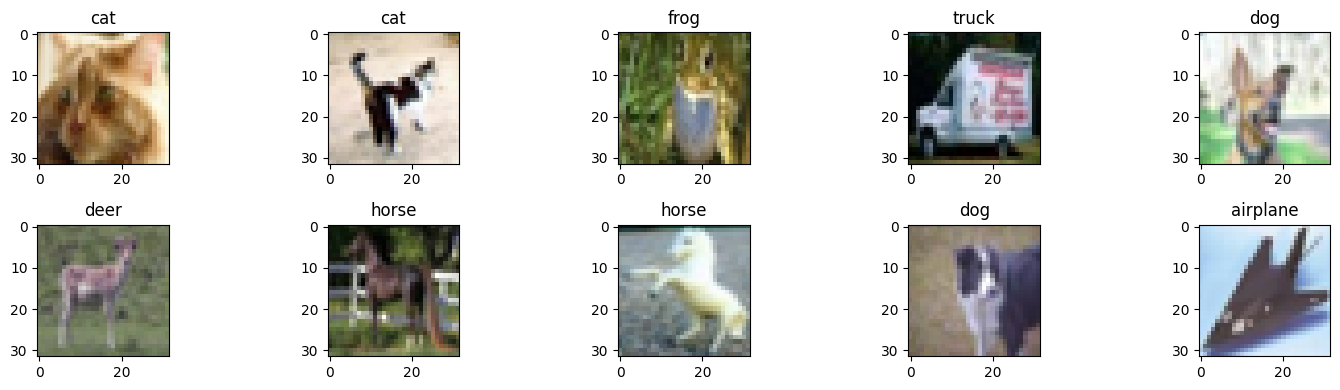

Building CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,025,002 (53.50 MB)

 Trainable params: 14,022,570 (53.49 MB)

 Non-trainable params: 2,432 (9.50 KB)

Model input shape: (None, 224, 224, 3)
Model output shape: (None, 10)
Training model with augmented data...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 256s 155ms/step - accuracy: 0.2636 - loss: 0.4840 - val_accuracy: 0.4520 - val_loss: 0.2425
Evaluating model on test data...
266/266 - 11s - 41ms/step - accuracy: 0.4579 - loss: 0.2420

Test Accuracy: 45.79%
Generating classification report...
266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step


              precision    recall  f1-score   support

           0       0.51      0.46      0.48       851
           1       0.65      0.59      0.62       848
           2       0.33      0.42      0.37       854
           3       0.39      0.25      0.31       849
           4       0.46      0.30      0.36       863
           5       0.50      0.40      0.44       874
           6       0.69      0.39      0.50       832
           7       0.70      0.46      0.55       851
           8       0.30      0.86      0.45       835
           9       0.60      0.45      0.51       843

    accuracy                           0.46      8500
   macro avg       0.51      0.46      0.46      8500
weighted avg       0.51      0.46      0.46      8500

Confusion matrix...
[[390  27  28   6   3   8   4   3 363  19]
 [ 15 503   3   2   3   2   5   2 232  81]
 [101  16 361  51  42  47  22  26 177  11]
 [ 58  31 103 214  52 154  30  11 160  36]
 [ 53  11 245  31 257  37  38  55 134   2]
 [ 26 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Raw prediction output: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


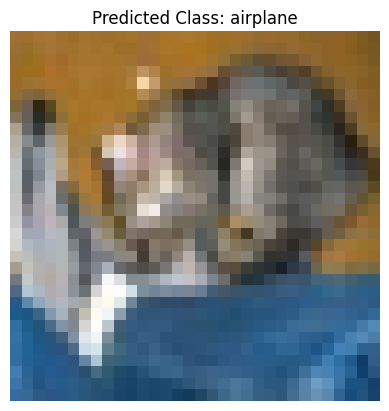

Predicted class for the sample image: airplane


In [22]:
if __name__ == "__main__":
  main()